In [34]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from rfpimp import * 
#import category_encoders as ce
from sklearn import preprocessing
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#import category_encoders as ce

## Steps taken in the Analysis:

1) Read the data   
2) Dropped any column/feature with 40% or more NULL values and the target variable columns as well   	
3) Replaced NULL values which are less then 40%   
4) Performed One hot encoding in the "State" column which is the only textual column   
5) Modified and balanced the target variable using SMOTE   
6) Applied following ML models:   
- Random Forest   
- Decision Tree
- Naive Bayes   

7) Found best model as Random Forest   
8) Got the probability values on test dataset   
9) Joined test dataset with these values to see the likelihood of customers being Engaged

In [21]:
df=pd.read_excel('/Users/nikhiljoshi/Capstone Project/Predicting CEP/Raw Data.xlsx')
df.head()

,Customer Number,onboarded Year,State,Age,# of Log Ins Last 30 Days,Customer Total Balance,# of Referrals Sent,Monthly AVG (EFT),Monthly AVG (Bill Payment),Monthly AVG (E-Transfer),Engaged,Joint Account (Y/N),Ever CD (Y/N),# of Products,Balance Active
0,1,2009,IL,49,NaN,0.81,NaN,NaN,NaN,NaN,No,NaN,NaN,1,1
1,2,2009,IL,56,17.0,122652.99,NaN,10.0,3.0,3.0,YES,NaN,YES,2,1
2,3,2006,IL,61,1.0,4031.08,NaN,2.0,1.0,1.0,YES,NaN,YES,2,1
3,4,2008,IL,36,18.0,31332.23,NaN,1.0,3.0,4.0,YES,NaN,YES,2,1
4,5,2006,IL,73,1.0,1099.80,NaN,1.0,NaN,1.0,YES,NaN,NaN,1,1


**We are dropping any column/feature with 40% or more NULL values and the target variable columns as well**

In [22]:
def sniff_modified(newdf):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = newdf.dtypes
        info['percent missing'] = newdf.isnull().sum()*100/len(newdf)
        info['No. unique'] = newdf.apply(lambda x: len(x.unique()))
        info['unique values'] = newdf.apply(lambda x: x.unique())
        return info.sort_values('data type')
sniff_modified(df)

,data type,percent missing,No. unique,unique values
Customer Number,int64,0.000000,2497,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
onboarded Year,int64,0.000000,5,"[2009, 2006, 2008, 2010, 2007]"
Age,int64,0.000000,61,"[49, 56, 61, 36, 73, 81, 39, 57, 63, 30, 40, 8..."
# of Products,int64,0.000000,8,"[1, 2, 4, 3, 6, 5, 7, 8]"
Balance Active,int64,0.000000,2,"[1, 0]"
# of Log Ins Last 30 Days,float64,47.979192,68,"[nan, 17.0, 1.0, 18.0, 22.0, 6.0, 8.0, 24.0, 1..."
Customer Total Balance,float64,0.000000,2115,"[0.81, 122652.99, 4031.08, 31332.23, 1099.8, 3..."
# of Referrals Sent,float64,93.797519,12,"[nan, 1.0, 11.0, 5.0, 2.0, 9.0, 7.0, 20.0, 3.0..."
Monthly AVG (EFT),float64,9.603842,16,"[nan, 10.0, 2.0, 1.0, 11.0, 4.0, 3.0, 5.0, 7.0..."
Monthly AVG (Bill Payment),float64,70.148059,13,"[nan, 3.0, 1.0, 2.0, 4.0, 9.0, 5.0, 11.0, 6.0,..."


In [23]:
newdf=df.drop(['# of Log Ins Last 30 Days','# of Referrals Sent','Monthly AVG (Bill Payment)','Monthly AVG (E-Transfer)'
              ,'Joint Account (Y/N)','Ever CD (Y/N)','Engaged'],axis=1)
sniff_modified(newdf)

,data type,percent missing,No. unique,unique values
Customer Number,int64,0.000000,2497,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
onboarded Year,int64,0.000000,5,"[2009, 2006, 2008, 2010, 2007]"
Age,int64,0.000000,61,"[49, 56, 61, 36, 73, 81, 39, 57, 63, 30, 40, 8..."
# of Products,int64,0.000000,8,"[1, 2, 4, 3, 6, 5, 7, 8]"
Balance Active,int64,0.000000,2,"[1, 0]"
Customer Total Balance,float64,0.000000,2115,"[0.81, 122652.99, 4031.08, 31332.23, 1099.8, 3..."
Monthly AVG (EFT),float64,9.603842,16,"[nan, 10.0, 2.0, 1.0, 11.0, 4.0, 3.0, 5.0, 7.0..."
State,object,0.000000,13,"[IL, WA, CA, TX, OH, MI, AZ, NY, VA, MA, GA, A..."


**Checking for Variability in column monthly AVG(EFT)**

<AxesSubplot:xlabel='Monthly AVG (EFT)', ylabel='Count'>

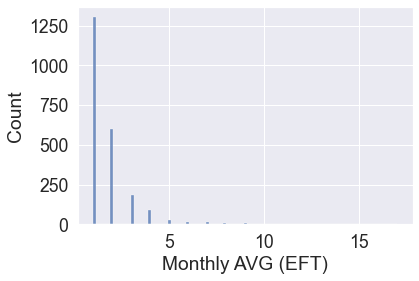

In [24]:
sns.histplot(newdf,x="Monthly AVG (EFT)")

**Filling the values for Median for column monthly AVG(EFT)**

In [25]:
newdf['Monthly AVG (EFT)'] = newdf['Monthly AVG (EFT)'].fillna(df['Monthly AVG (EFT)'].median())
sniff_modified(newdf)

,data type,percent missing,No. unique,unique values
Customer Number,int64,0.0,2497,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
onboarded Year,int64,0.0,5,"[2009, 2006, 2008, 2010, 2007]"
Age,int64,0.0,61,"[49, 56, 61, 36, 73, 81, 39, 57, 63, 30, 40, 8..."
# of Products,int64,0.0,8,"[1, 2, 4, 3, 6, 5, 7, 8]"
Balance Active,int64,0.0,2,"[1, 0]"
Customer Total Balance,float64,0.0,2115,"[0.81, 122652.99, 4031.08, 31332.23, 1099.8, 3..."
Monthly AVG (EFT),float64,0.0,15,"[1.0, 10.0, 2.0, 11.0, 4.0, 3.0, 5.0, 7.0, 15...."
State,object,0.0,13,"[IL, WA, CA, TX, OH, MI, AZ, NY, VA, MA, GA, A..."


**Performing One hot encoding on the only non numeric column which is important in the data (State)**

In [26]:
Onehot_encoding=pd.get_dummies(newdf['State'])
finaldf=pd.concat([newdf,Onehot_encoding],axis=1)
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer Number         2499 non-null   int64  
 1   onboarded Year          2499 non-null   int64  
 2   State                   2499 non-null   object 
 3   Age                     2499 non-null   int64  
 4   Customer Total Balance  2499 non-null   float64
 5   Monthly AVG (EFT)       2499 non-null   float64
 6   # of Products           2499 non-null   int64  
 7   Balance Active          2499 non-null   int64  
 8   AK                      2499 non-null   uint8  
 9   AZ                      2499 non-null   uint8  
 10  CA                      2499 non-null   uint8  
 11  GA                      2499 non-null   uint8  
 12  IL                      2499 non-null   uint8  
 13  MA                      2499 non-null   uint8  
 14  MI                      2499 non-null   

In [27]:
finaldf2=finaldf.drop('State',axis=1)
finaldf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer Number         2499 non-null   int64  
 1   onboarded Year          2499 non-null   int64  
 2   Age                     2499 non-null   int64  
 3   Customer Total Balance  2499 non-null   float64
 4   Monthly AVG (EFT)       2499 non-null   float64
 5   # of Products           2499 non-null   int64  
 6   Balance Active          2499 non-null   int64  
 7   AK                      2499 non-null   uint8  
 8   AZ                      2499 non-null   uint8  
 9   CA                      2499 non-null   uint8  
 10  GA                      2499 non-null   uint8  
 11  IL                      2499 non-null   uint8  
 12  MA                      2499 non-null   uint8  
 13  MI                      2499 non-null   uint8  
 14  NY                      2499 non-null   

**Modifying target variable**

In [28]:
print(df['Engaged'].unique())

['No' 'YES']


**Replacing nan values with "NO" for the sake of analysis**

In [29]:
#replacing No with 0 and considering NULL values as No
df['Engaged']=df['Engaged'].fillna("No")
df['Engaged']=df['Engaged'].map(
                    {'YES':1, 'No':0})


/Users/nikhiljoshi/miniforge3/envs/mlp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Target Variable')

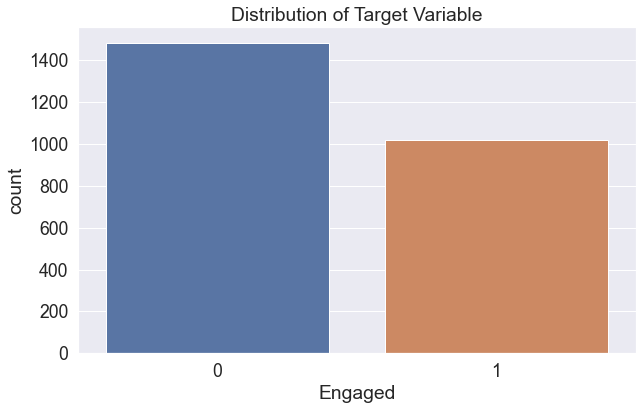

In [30]:
# viewing the data
plt.figure(figsize=(10,6))
sns.countplot('Engaged', data=df).set_title('Distribution of Target Variable')

**Defining X and y variables for ML Model**

In [31]:
X = finaldf2
y=df['Engaged']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.20, random_state = 0)

**Balancing Data using SMOTE**

In [32]:
from collections import Counter
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE: ",Counter(y_train))
print("After SMOTE: ",Counter(y_res))

Before SMOTE:  Counter({0: 1184, 1: 815})
After SMOTE:  Counter({1: 1184, 0: 1184})


              precision    recall  f1-score   support

           0       0.75      0.83      0.79       299
           1       0.70      0.59      0.64       201

    accuracy                           0.73       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.73      0.73      0.73       500



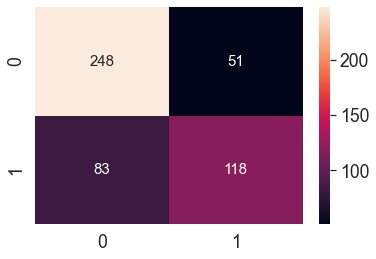

In [36]:
X_res, X_test, y_res, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)

# Defining the classifier used
model = RandomForestClassifier(n_estimators = 12, criterion = 'entropy', random_state=0) 

model.fit(X_res, y_res)     # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = model.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(2),range(2))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.79      0.78       299
           1       0.67      0.63      0.65       201

    accuracy                           0.73       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.73      0.73      0.73       500



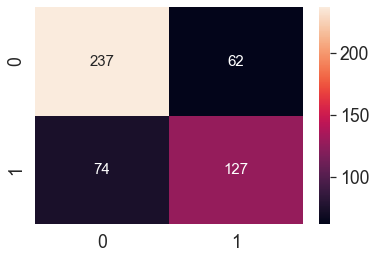

In [37]:
from sklearn.tree import DecisionTreeClassifier
X_res, X_test, y_res, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)

dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state= 0) # Defining the classifier used
dt_clf.fit(X_res, y_res)  # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = dt_clf.predict(X_test)


# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(2),range(2))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.94      0.75       299
           1       0.66      0.18      0.29       201

    accuracy                           0.63       500
   macro avg       0.65      0.56      0.52       500
weighted avg       0.64      0.63      0.57       500



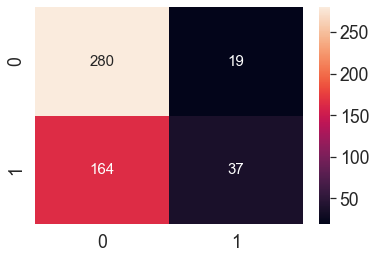

In [38]:
from sklearn.naive_bayes import GaussianNB
X_res, X_test, y_res, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)
classifierused = GaussianNB()   # Defining the classifier used
classifierused.fit(X_res, y_res)     # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = classifierused.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(2),range(2))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


**Getting Probability to see likelihood of Customer getting "Engaged"**

In [51]:
predictions = np.round((model.predict_proba(X_test))*100)
predictionsdf=pd.DataFrame(predictions,columns=['Yes(in %)','No(in %)'])
predictionsdf.reset_index(drop=True)
predictionsdf.head()

,Yes(in %),No(in %)
0,25.0,75.0
1,92.0,8.0
2,83.0,17.0
3,58.0,42.0
4,0.0,100.0


**Joining prediction probabilities with test dataset**

In [54]:
outcomedf=pd.merge(X_test, predictionsdf, left_index=True, right_index=True)
outcomedf

,Customer Number,onboarded Year,Age,Customer Total Balance,Monthly AVG (EFT),# of Products,Balance Active,AK,AZ,CA,...,MA,MI,NY,OH,OR,TX,VA,WA,Yes(in %),No(in %)
53,54,2010,62,14915.84,1.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0,100.0
326,327,2007,60,258.30,1.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,33.0,67.0
330,331,2010,70,99723.51,1.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,17.0,83.0
33,34,2008,45,56639.30,1.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,75.0,25.0
195,196,2008,47,0.00,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,33.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,2008,29,28313.33,1.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,58.0,42.0
220,221,2006,83,0.15,1.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,17.0,83.0
317,318,2008,31,0.00,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,75.0,25.0
191,192,2009,59,8941.22,1.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,67.0,33.0
